# 目次
1. コレスキー分解
2. lapack

# 0. 準備

In [55]:
import scipy 
from scipy.linalg import solve_triangular
from scipy.linalg.lapack import dpotrf, dtrtri, dpotrs, dpotri

import numpy as np
import pandas as pd
import pods 

import sys
sys.path.append('../')
from linalg_util import *

In [56]:
import linalg_util
import importlib
importlib.reload(linalg_util)

<module 'linalg_util' from '/home/onoue/ws/SGPR/experiments/../linalg_util.py'>

ディレクトリ構造

- SGPR
  - experiments
    - linalg.ipynb
    - gp_util.ipynb
  - gp_util.py
  - gpregression.py
  - linalg_util.py




linalg_util

```
generate_pd_matrix
generate_non_pd_matrix
symmetrify_matrix
customized_cholesky
```

# 1. コレスキー分解と jitter

In [57]:
A = generate_non_pd_matrix()
print(A.shape)
display(pd.DataFrame(A).head())

(20, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,99.223791,-0.790073,13.838702,0.566494,-27.271211,7.424425,1.513125,-7.533860,7.971692,2.059587,-13.299077,-3.113528,-0.920612,10.189653,1.160385,14.640696,-3.739880,1.323948,0.687870,4.698655
1,-0.790073,105.406136,15.390001,-0.259782,-19.830824,7.960421,13.718535,0.272280,6.862899,-9.558036,-14.523893,12.730293,0.953555,7.281044,-0.683202,-8.033015,5.988674,21.477499,-8.345360,8.805631
2,13.838702,15.390001,100.104677,15.368705,-6.883902,9.866024,6.013517,-4.239108,-2.874373,-14.262783,-13.417558,1.844495,-12.739228,4.785183,-11.792796,9.965225,-2.805905,16.585636,12.637003,12.382333
3,0.566494,-0.259782,15.368705,92.352574,2.624361,3.153858,-5.938488,-16.747368,5.115192,-11.930478,3.434771,6.808770,-9.016764,17.618645,-3.125280,-4.449317,6.852155,-9.838031,-15.604141,9.454366
4,-27.271211,-19.830824,-6.883902,2.624361,113.415845,5.556679,-4.030063,-5.398222,-3.904928,0.552163,6.802024,-5.877293,5.455667,-8.581159,1.486108,-4.532525,-1.012721,-8.456516,8.029569,0.789551


In [58]:
scipy.linalg.cholesky(A)

LinAlgError: 20-th leading minor of the array is not positive definite

GPy の jitchol 関数と同じ処理

なぜ対角成分の平均値を用いて jitter の初期値を設定することについての正当性は今の所わからない


```python
def customized_cholesky(A, max_tries=5):
    A = np.ascontiguousarray(A) 
    diag_A = np.diag(A)
    jitter = diag_A.mean() * 1e-6 
    num_tries = 0
    
    try:
        L = cholesky(A, lower=True)
        return L
    except LinAlgError:
        num_tries += 1
        
    while num_tries <= max_tries and np.isfinite(jitter):
        try:
            L = cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
            return L
        except LinAlgError:
            jitter *= 10
            num_tries += 1
    
    raise LinAlgError("Matrix is not positive definite, even with jitter.")
```

In [59]:
pd.DataFrame(customized_cholesky(A))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,10.009606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.078931,10.313503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.382542,1.502800,9.843946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.056595,-0.024755,1.557065,9.533768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-2.724504,-1.943653,-0.019935,0.289652,10.153781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.741730,0.777521,0.779372,0.201137,0.890903,8.915524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.151167,1.331310,0.386413,-0.683440,-0.081245,-1.633417,8.687544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,-0.752663,0.020640,-0.328073,-1.698534,-0.681844,-0.173084,-2.235169,8.790631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.796404,0.671524,-0.506362,0.616250,-0.060914,-0.624220,-0.300606,-0.691028,10.281835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.205761,-0.925175,-1.336548,-1.036729,-0.040558,-2.214311,-0.439283,0.550709,-0.406557,9.875295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 2. LAPACK (Linear Algebra Package)

LAPACK は FORTRAN の線形代数の数値計算用ライブラリで scipy からも呼び出して使用できる．

丸め誤差等の問題から数式上では同等でも計算結果が微妙に異なる場合があるのでそれを実際に確認したい．

<!-- ## 2.1 ~~Is $A \backslash y == L^\top \backslash (L \backslash y)$ ?~~ -->
## 2.1 線型方程式を解く

ある $n \times n$ の実正定値対称行列 $A$ と $n \times m$ の行列 $y$ に対して

$$
A x = y
$$

を満たすような $n\times m$ の行列 $x$ を求めたい．

ここで $A = LL^\top$ のようにコレスキー分解をすると $x$ は

$$
x = L^\top \backslash (L \backslash y)
$$

のようにして計算できる． 

LAPACK には `DPOTRS` という上記の線型方程式 $Ax = y$ を解く関数が存在する．
ただし，引数の１つには $A$ そのものではなく $L$ を渡す点には注意が必要であり，結局のところ `scipy.linalg.solve_triangular` を２度適用するのと同等であることが確認できる．

In [44]:
A = generate_non_pd_matrix()
b = np.random.rand(A.shape[0],1)
# c = np.eye(A.shape[0])

L = customized_cholesky(A)

In [45]:
A_y, _ = dpotrs(L, b, lower=True) # 引数は三角行列を与える
LT_L_y = solve_triangular(L.T, solve_triangular(L, b, lower=True))

np.unique(A_y == LT_L_y)

array([ True])

## 2.2 逆行列を求める

実正定値対称行列 $A$ の逆行列を以下の4パターンで求めて比較する．

1. `DPOTRI` (LAPACK)
   
2. 線型方程式を解く
$$
A^{-1} = A \backslash I
$$

3. Moorepenrose の疑似逆行列 (`numpy.linalg.pinv`)


1. コレスキー分解してから逆行列を求めて掛け合わせる
$$
A^{-1} = L^{-\top}L^{-1}
$$

結果として，1〜4の計算方法は互いに微妙に結果が一致しなかった．GPyでは1を採用していて，コメントアウトして消されてはいたが2を試した痕跡があった．

In [46]:
# 正定値行列の生成
A = np.random.randn(20, 100)
A = A @ A.T

L = customized_cholesky(A)

In [47]:
A_inv, info = dpotri(L, lower=True)
print(info) # 0 が返却されたら成功
display(pd.DataFrame(A_inv).head())

0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012322,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.000204,0.011815,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000326,0.000641,0.012060,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.000840,-0.002726,0.000530,0.014443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.001054,-0.002114,0.000696,0.001435,0.011718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
A_inv = symmetrify_matrix(A_inv)
display(pd.DataFrame(A_inv).head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012322,-0.000204,0.000326,-0.000840,-0.001054,-0.000148,0.000585,0.000482,-0.000616,0.002010,0.000634,0.001019,0.000828,0.001239,0.000679,0.001414,-0.000581,-0.003330,-0.000996,-0.000255
1,-0.000204,0.011815,0.000641,-0.002726,-0.002114,-0.001134,0.000119,0.000396,-0.001072,0.000923,0.000103,0.000952,-0.000418,0.001052,-0.000751,0.001376,0.001199,0.000137,0.001342,0.000092
2,0.000326,0.000641,0.012060,0.000530,0.000696,0.000231,0.000489,-0.000787,0.001453,-0.001286,-0.000418,-0.000323,0.000329,0.000502,0.000996,-0.001895,-0.002054,0.000834,0.000299,-0.000387
3,-0.000840,-0.002726,0.000530,0.014443,0.001435,-0.000906,0.000240,-0.002520,-0.001804,-0.001881,-0.001685,-0.002652,0.000100,0.001671,0.001131,-0.001199,0.000461,0.000349,-0.000232,0.000686
4,-0.001054,-0.002114,0.000696,0.001435,0.011718,0.000208,0.000399,-0.000836,0.002110,-0.000647,-0.001091,0.000598,-0.000051,0.000276,0.001379,-0.000767,-0.000872,-0.000433,-0.000443,0.000681


In [49]:
A_inv_2 = solve_triangular(L.T, solve_triangular(L, np.eye(A.shape[0]), lower=True))
display(pd.DataFrame(A_inv_2).head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012322,-0.000204,0.000326,-0.000840,-0.001054,-0.000148,0.000585,0.000482,-0.000616,0.002010,0.000634,0.001019,0.000828,0.001239,0.000679,0.001414,-0.000581,-0.003330,-0.000996,-0.000255
1,-0.000204,0.011815,0.000641,-0.002726,-0.002114,-0.001134,0.000119,0.000396,-0.001072,0.000923,0.000103,0.000952,-0.000418,0.001052,-0.000751,0.001376,0.001199,0.000137,0.001342,0.000092
2,0.000326,0.000641,0.012060,0.000530,0.000696,0.000231,0.000489,-0.000787,0.001453,-0.001286,-0.000418,-0.000323,0.000329,0.000502,0.000996,-0.001895,-0.002054,0.000834,0.000299,-0.000387
3,-0.000840,-0.002726,0.000530,0.014443,0.001435,-0.000906,0.000240,-0.002520,-0.001804,-0.001881,-0.001685,-0.002652,0.000100,0.001671,0.001131,-0.001199,0.000461,0.000349,-0.000232,0.000686
4,-0.001054,-0.002114,0.000696,0.001435,0.011718,0.000208,0.000399,-0.000836,0.002110,-0.000647,-0.001091,0.000598,-0.000051,0.000276,0.001379,-0.000767,-0.000872,-0.000433,-0.000443,0.000681


In [50]:
A_inv_3 = np.linalg.pinv(A)
display(pd.DataFrame(A_inv_3).head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012322,-0.000204,0.000326,-0.000840,-0.001054,-0.000148,0.000585,0.000482,-0.000616,0.002010,0.000634,0.001019,0.000828,0.001239,0.000679,0.001414,-0.000581,-0.003330,-0.000996,-0.000255
1,-0.000204,0.011815,0.000641,-0.002726,-0.002114,-0.001134,0.000119,0.000396,-0.001072,0.000923,0.000103,0.000952,-0.000418,0.001052,-0.000751,0.001376,0.001199,0.000137,0.001342,0.000092
2,0.000326,0.000641,0.012060,0.000530,0.000696,0.000231,0.000489,-0.000787,0.001453,-0.001286,-0.000418,-0.000323,0.000329,0.000502,0.000996,-0.001895,-0.002054,0.000834,0.000299,-0.000387
3,-0.000840,-0.002726,0.000530,0.014443,0.001435,-0.000906,0.000240,-0.002520,-0.001804,-0.001881,-0.001685,-0.002652,0.000100,0.001671,0.001131,-0.001199,0.000461,0.000349,-0.000232,0.000686
4,-0.001054,-0.002114,0.000696,0.001435,0.011718,0.000208,0.000399,-0.000836,0.002110,-0.000647,-0.001091,0.000598,-0.000051,0.000276,0.001379,-0.000767,-0.000872,-0.000433,-0.000443,0.000681


In [51]:
L_inv, _ = dtrtri(L, lower=True)

A_inv_4 = L_inv.T @ L_inv
display(pd.DataFrame(A_inv_4).head()) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012322,-0.000204,0.000326,-0.000840,-0.001054,-0.000148,0.000585,0.000482,-0.000616,0.002010,0.000634,0.001019,0.000828,0.001239,0.000679,0.001414,-0.000581,-0.003330,-0.000996,-0.000255
1,-0.000204,0.011815,0.000641,-0.002726,-0.002114,-0.001134,0.000119,0.000396,-0.001072,0.000923,0.000103,0.000952,-0.000418,0.001052,-0.000751,0.001376,0.001199,0.000137,0.001342,0.000092
2,0.000326,0.000641,0.012060,0.000530,0.000696,0.000231,0.000489,-0.000787,0.001453,-0.001286,-0.000418,-0.000323,0.000329,0.000502,0.000996,-0.001895,-0.002054,0.000834,0.000299,-0.000387
3,-0.000840,-0.002726,0.000530,0.014443,0.001435,-0.000906,0.000240,-0.002520,-0.001804,-0.001881,-0.001685,-0.002652,0.000100,0.001671,0.001131,-0.001199,0.000461,0.000349,-0.000232,0.000686
4,-0.001054,-0.002114,0.000696,0.001435,0.011718,0.000208,0.000399,-0.000836,0.002110,-0.000647,-0.001091,0.000598,-0.000051,0.000276,0.001379,-0.000767,-0.000872,-0.000433,-0.000443,0.000681


In [52]:
A_invs = [A_inv, A_inv_2, A_inv_3, A_inv_4]
A_invs_name = ["A_inv", "A_inv_2", "A_inv_3", "A_inv_4"]

df = pd.DataFrame(columns=range(4), index=range(4))

for i in range(len(A_invs)):
    for j in range(len(A_invs)):
        df.iloc[i, j] = np.unique(A_invs[i] == A_invs[j])

df.columns, df.index = A_invs_name, A_invs_name
display(df)

,A_inv,A_inv_2,A_inv_3,A_inv_4
A_inv,[True],"[False, True]","[False, True]","[False, True]"
A_inv_2,"[False, True]",[True],"[False, True]","[False, True]"
A_inv_3,"[False, True]","[False, True]",[True],"[False, True]"
A_inv_4,"[False, True]","[False, True]","[False, True]",[True]


In [53]:
threshold = 1e-13

df2 = pd.DataFrame(columns=range(4), index=range(4))

for i in range(len(A_invs)):
    for j in range(len(A_invs)):
        df2.iloc[i, j] = np.sum(np.abs(A_invs[i] - A_invs[j]) > threshold)

df2.columns, df2.index = A_invs_name, A_invs_name
display(df2)

,A_inv,A_inv_2,A_inv_3,A_inv_4
A_inv,0,0,0,0
A_inv_2,0,0,0,0
A_inv_3,0,0,0,0
A_inv_4,0,0,0,0


## 2.3 np.ascontiguousarray（未）



In [ ]:
np.random.seed(seed=0)

def contiguous():
    A = np.random.randn(20, 100)
    A = A @ A.T
    



In [ ]:
import timeit

def my_function():
    # 測定したい処理
    pass

execution_time = timeit.timeit(my_function, number=1000)  # 1000回実行して平均実行時間を計測
print("Execution time: ", execution_time, "seconds")


## 2.4 np.asfortranarray（未）

## 2.5 moore-penrose の疑似逆行列

おそらく使用しない

-------------------------------------------------------------------


,0
0,0.097627
1,0.430379
2,0.205527
3,0.089766
4,-0.152690


,0,1,2,3,4
0,0.363777,1.603674,0.765832,0.334487,-0.568954


,0,1,2,3,4
0,0.035514,0.156562,0.074766,0.032655,-0.055545
1,0.156562,0.690187,0.329598,0.143956,-0.244866
2,0.074766,0.329598,0.157399,0.068746,-0.116935
3,0.032655,0.143956,0.068746,0.030026,-0.051073
4,-0.055545,-0.244866,-0.116935,-0.051073,0.086874


,0
0,1.0


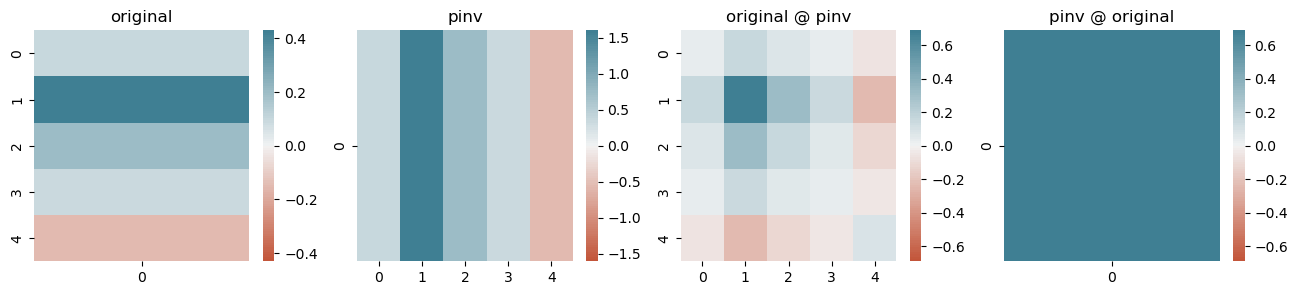



-------------------------------------------------------------------


,0,1
0,0.291788,-0.124826
1,0.783546,0.927326
2,-0.233117,0.583450
3,0.057790,0.136089
4,0.851193,-0.857928


,0,1,2,3,4
0,0.191645,0.588108,-0.124958,0.047315,0.530322
1,-0.046986,0.520817,0.285426,0.073103,-0.390112


,0,1,2,3,4
0,0.061785,0.106592,-0.072090,0.004681,0.203438
1,0.106592,0.943776,0.166773,0.104864,0.053771
2,-0.072090,0.166773,0.195662,0.031622,-0.351238
3,0.004681,0.104864,0.031622,0.012683,-0.022443
4,0.203438,0.053771,-0.351238,-0.022443,0.786094


,0,1
0,1.0,-5.551115e-17
1,0.0,1.000000e+00


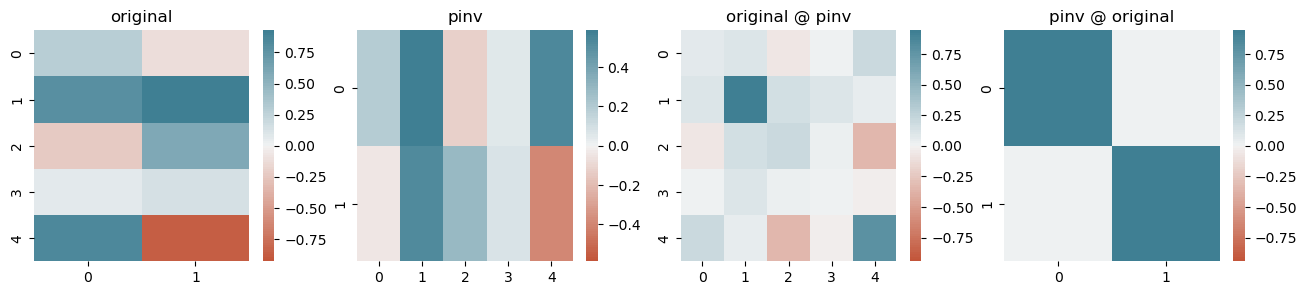



-------------------------------------------------------------------


,0,1,2
0,-0.825741,-0.959563,0.665240
1,0.556314,0.740024,0.957237
2,0.598317,-0.077041,0.561058
3,-0.763451,0.279842,-0.713293
4,0.889338,0.043697,-0.170676


,0,1,2,3,4
0,-0.238911,-0.170289,0.245203,-0.381998,0.516238
1,-0.426400,0.646384,-0.186126,0.402261,-0.329706
2,0.342930,0.540318,0.159618,-0.166818,-0.270172


,0,1,2,3,4
0,0.834567,-0.120191,0.082310,-0.181537,-0.289635
1,-0.120191,0.900818,0.151465,-0.074512,-0.215419
2,0.082310,0.151465,0.250604,-0.353141,0.182692
3,-0.181537,-0.074512,-0.353141,0.523196,-0.293676
4,-0.289635,-0.215419,0.182692,-0.293676,0.490815


,0,1,2
0,1.000000e+00,-2.275695e-16,-7.228579e-18
1,-1.330675e-16,1.000000e+00,3.746913e-16
2,2.859271e-17,5.378422e-16,1.000000e+00


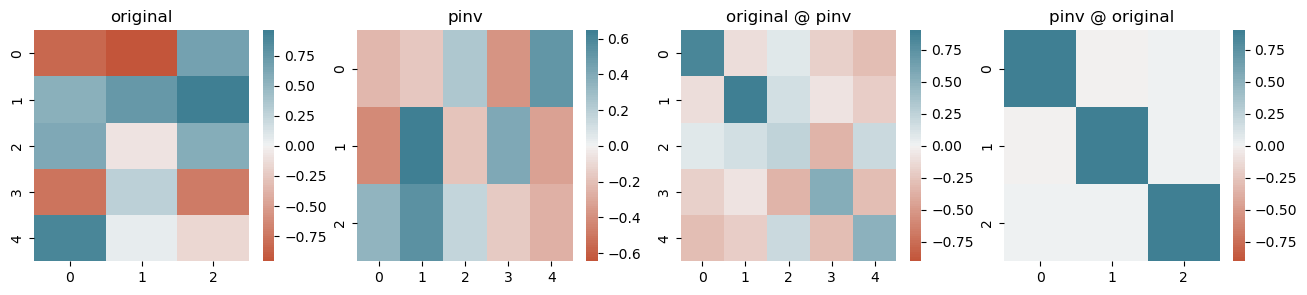



-------------------------------------------------------------------


,0,1,2,3
0,-0.470889,0.548467,-0.087699,0.136868
1,-0.962420,0.235271,0.224191,0.233868
2,0.887496,0.363641,-0.280984,-0.125936
3,0.395262,-0.879549,0.333533,0.341276
4,-0.579235,-0.742147,-0.369143,-0.272578


,0,1,2,3,4
0,-0.133647,-0.362267,0.381740,0.216534,-0.283190
1,0.158330,0.123820,0.111958,-0.521232,-0.518587
2,-2.496965,0.083223,-1.819047,-0.971743,-1.558596
3,3.032574,0.614455,1.589003,2.284385,0.507215


,0,1,2,3,4
0,0.783816,0.315299,0.258661,0.010038,0.055032
1,0.315299,0.540144,-0.377251,-0.014640,-0.080263
2,0.258661,-0.377251,0.690515,-0.012010,-0.065845
3,0.010038,-0.014640,-0.012010,0.999534,-0.002555
4,0.055032,-0.080263,-0.065845,-0.002555,0.985991


,0,1,2,3
0,1.000000e+00,-1.793990e-16,2.406203e-17,-3.626274e-17
1,-4.773667e-17,1.000000e+00,2.109366e-16,-3.300766e-17
2,1.966190e-16,-2.082905e-15,1.000000e+00,4.103903e-16
3,-3.326848e-16,7.419638e-16,-5.524449e-16,1.000000e+00


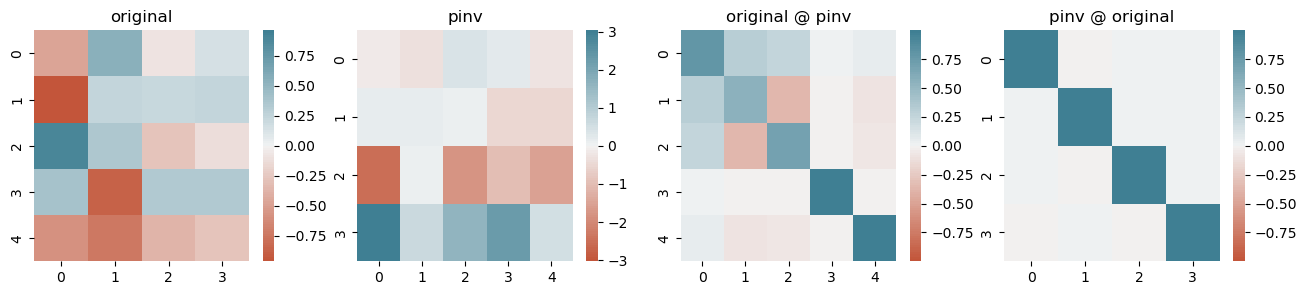



-------------------------------------------------------------------


,0,1,2,3,4
0,0.140394,-0.122797,0.976748,-0.795910,-0.582246
1,-0.677381,0.306217,-0.493417,-0.067378,-0.511149
2,-0.682061,-0.779250,0.312659,-0.723634,-0.606835
3,-0.262550,0.641986,-0.805797,0.675890,-0.807803
4,0.952919,-0.062698,0.953522,0.209691,0.478527


,0,1,2,3,4
0,1.233013,-3.933101,-0.835918,0.874007,-2.285600
1,0.446585,2.014955,-1.040167,-0.534204,0.474839
2,-0.590478,3.019223,0.688992,-0.462953,2.598805
3,-1.383194,1.735122,1.096300,0.468093,2.350852
4,-0.614142,1.319724,-0.324971,-1.093084,0.494836


,0,1,2,3,4
0,1.000000e+00,-4.786875e-16,-1.156547e-16,-2.992999e-16,-7.230061e-17
1,2.582551e-16,1.000000e+00,-7.766252e-17,6.408989e-17,5.546053e-16
2,2.606388e-16,-5.000392e-16,1.000000e+00,-1.181448e-16,-6.629837e-16
3,7.539138e-17,-6.791726e-16,8.067391e-18,1.000000e+00,-2.637437e-16
4,-3.781549e-16,2.705155e-16,1.981023e-16,2.890818e-16,1.000000e+00


,0,1,2,3,4
0,1.000000e+00,-1.836006e-15,-3.336764e-16,-1.021135e-15,2.233757e-15
1,1.236806e-16,1.000000e+00,5.281572e-16,2.954822e-16,-5.331648e-16
2,-3.222946e-16,1.511393e-15,1.000000e+00,1.046965e-15,-1.842286e-15
3,-3.479831e-16,9.033146e-16,-7.399234e-17,1.000000e+00,-1.262259e-15
4,-2.746001e-16,1.074236e-15,-1.278465e-16,6.803751e-16,1.000000e+00


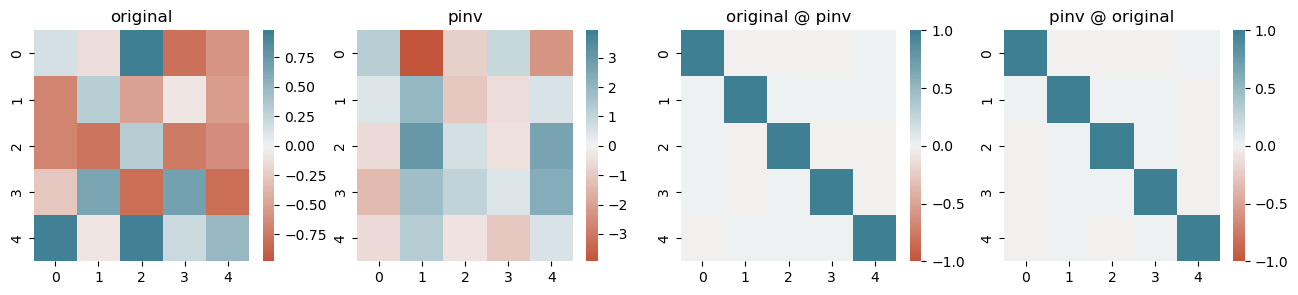



-------------------------------------------------------------------


,0,1,2,3,4,5
0,-0.921624,-0.434386,-0.759607,-0.407720,-0.762545,-0.364034
1,-0.171474,-0.871705,0.384944,0.133203,-0.469221,0.046496
2,-0.812119,0.151893,0.858592,-0.362862,0.334821,-0.736404
3,0.432654,-0.421188,-0.633617,0.173026,-0.959785,0.657880
4,-0.990609,0.355633,-0.459984,0.470388,0.924377,-0.502494


,0,1,2,3,4
0,0.187735,0.137241,-1.263527,-1.401803,-0.654730
1,-0.652462,-1.381598,1.787594,2.112467,0.339174
2,-0.681801,0.095807,1.223639,0.948112,0.013787
3,-0.911245,0.217691,0.916819,1.736574,0.968666
4,0.269505,0.505733,-1.527210,-2.010882,-0.075152
5,-0.564995,-0.201946,0.684738,1.317101,0.296603


,0,1,2,3,4
0,1.000000e+00,3.942109e-16,-1.053740e-16,-4.565195e-16,7.298361e-17
1,-4.452948e-16,1.000000e+00,1.111402e-15,1.089977e-15,2.072494e-16
2,5.886998e-16,-2.221353e-16,1.000000e+00,-1.144807e-15,-5.460118e-16
3,-3.002280e-16,2.465480e-17,6.839733e-17,1.000000e+00,1.598588e-16
4,6.162675e-16,-2.473125e-16,-1.461151e-15,-1.560349e-15,1.000000e+00


,0,1,2,3,4,5
0,0.871665,-0.035526,0.014743,-0.150302,0.109604,0.275286
1,-0.035526,0.990166,0.004081,-0.041607,0.030341,0.076205
2,0.014743,0.004081,0.998306,0.017266,-0.012591,-0.031624
3,-0.150302,-0.041607,0.017266,0.823972,0.128364,0.322405
4,0.109604,0.030341,-0.012591,0.128364,0.906394,-0.235106
5,0.275286,0.076205,-0.031624,0.322405,-0.235106,0.409497


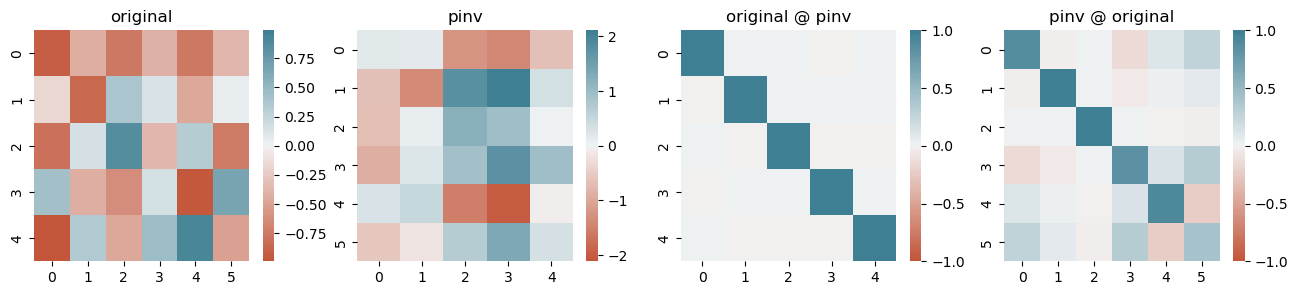



-------------------------------------------------------------------


,0,1,2,3,4,5,6
0,0.152315,0.184084,0.144504,-0.553837,0.905498,-0.105749,0.692817
1,0.398959,-0.405126,0.627596,-0.206989,0.762206,0.162546,0.763471
2,0.385063,0.450509,0.002649,0.912167,0.287980,-0.152290,0.212786
3,-0.961614,-0.396850,0.320347,-0.419845,0.236031,-0.142463,-0.729052
4,-0.403435,0.139930,0.181746,0.148650,0.306402,0.304207,-0.137163


,0,1,2,3,4
0,-0.148785,0.276810,0.116282,-0.239462,-0.686628
1,0.665942,-0.769893,0.074651,-0.381262,0.688698
2,-0.436522,0.670987,0.171082,0.298784,0.071238
3,-0.546690,0.245164,0.760352,0.113827,0.169106
4,0.523522,0.045229,0.466876,0.383965,0.162334
5,-0.409955,0.234559,-0.925450,-0.974024,1.842074
6,0.206366,0.176429,-0.224714,-0.467884,0.157290


,0,1,2,3,4
0,1.000000e+00,1.591707e-16,5.653766e-17,-2.201255e-16,7.196065e-17
1,-2.787470e-16,1.000000e+00,-1.599829e-17,-1.841027e-16,9.332722e-17
2,1.043719e-16,-1.917604e-17,1.000000e+00,-1.881450e-17,-1.695225e-17
3,-8.278079e-17,5.471416e-17,2.479947e-16,1.000000e+00,1.919513e-16
4,-8.257199e-18,-4.409476e-17,-3.267191e-17,-4.830693e-17,1.000000e+00


,0,1,2,3,4,5,6
0,0.639829,-0.088195,-0.048970,0.129644,-0.157156,-0.131743,0.401758
1,-0.088195,0.715797,-0.383721,0.121076,0.158719,0.056888,0.072967
2,-0.048970,-0.383721,0.467144,0.144078,0.257779,0.108279,0.018653
3,0.129644,0.121076,0.144078,0.922947,-0.010513,0.017096,-0.135969
4,-0.157156,0.158719,0.257779,-0.010513,0.783341,-0.124428,0.194385
5,-0.131743,0.056888,0.108279,0.017096,-0.124428,0.921549,0.155581
6,0.401758,0.072967,0.018653,-0.135969,0.194385,0.155581,0.549393


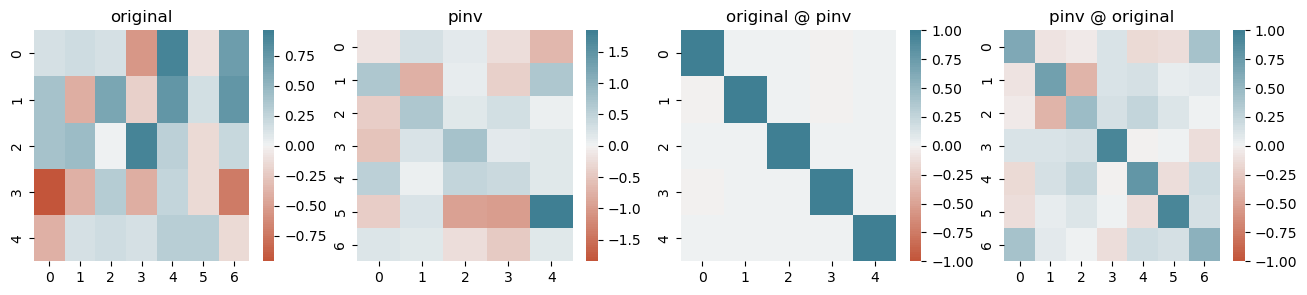



-------------------------------------------------------------------


,0,1,2,3,4,5,6,7
0,0.793093,-0.264876,-0.128270,0.783847,0.612388,0.407777,-0.799546,0.838965
1,0.428483,0.997694,-0.701103,0.736252,-0.675014,0.231119,-0.752360,0.696016
2,0.614638,0.138201,-0.185633,-0.861666,0.394858,-0.092915,0.444111,0.732765
3,0.951043,0.711607,-0.976572,-0.280044,0.459981,-0.656741,0.042073,-0.891324
4,-0.600007,-0.962956,0.587395,-0.552151,-0.309297,0.856163,0.408829,-0.936322


,0,1,2,3,4
0,0.321003,0.123318,0.264990,0.303050,0.248040
1,-0.309533,0.274288,0.047364,0.048911,-0.172936
2,-0.005608,-0.253752,-0.083551,-0.261882,-0.144188
3,0.192189,-0.088963,-0.537481,-0.049612,-0.259144
4,0.332345,-0.498883,-0.040014,0.121090,-0.233770
5,0.254856,0.449189,0.247431,0.027743,0.708231
6,-0.241781,-0.101628,0.237598,-0.053390,-0.037408
7,0.013466,0.063314,0.389227,-0.417478,-0.278251


,0,1,2,3,4
0,1.000000e+00,-1.009507e-16,-1.169574e-17,2.368669e-16,1.018003e-16
1,-2.999019e-16,1.000000e+00,-2.137563e-16,2.490470e-16,1.052156e-16
2,1.569294e-16,1.836943e-16,1.000000e+00,-2.693435e-16,-6.800769e-18
3,-2.274293e-17,-5.710179e-17,-5.713157e-17,1.000000e+00,8.001949e-17
4,1.070756e-16,-6.088042e-17,2.793530e-16,1.347245e-16,1.000000e+00


,0,1,2,3,4,5,6,7
0,0.609685,0.051430,-0.327077,-0.107746,0.280650,0.148115,-0.117595,0.046956
1,0.051430,0.563523,-0.310739,0.000296,-0.280013,-0.247411,-0.006486,0.084256
2,-0.327077,-0.310739,0.365187,0.033724,0.058998,-0.004630,0.088324,0.125883
3,-0.107746,0.000296,0.033724,0.705258,0.022849,-0.081538,-0.433467,-0.007664
4,0.280650,-0.280013,0.058998,0.022849,0.652481,-0.255731,0.001366,0.013228
5,0.148115,-0.247411,-0.004630,-0.081538,-0.255731,0.772892,-0.141121,0.019906
6,-0.117595,-0.006486,0.088324,-0.433467,0.001366,-0.141121,0.357756,-0.016864
7,0.046956,0.084256,0.125883,-0.007664,0.013228,0.019906,-0.016864,0.973218


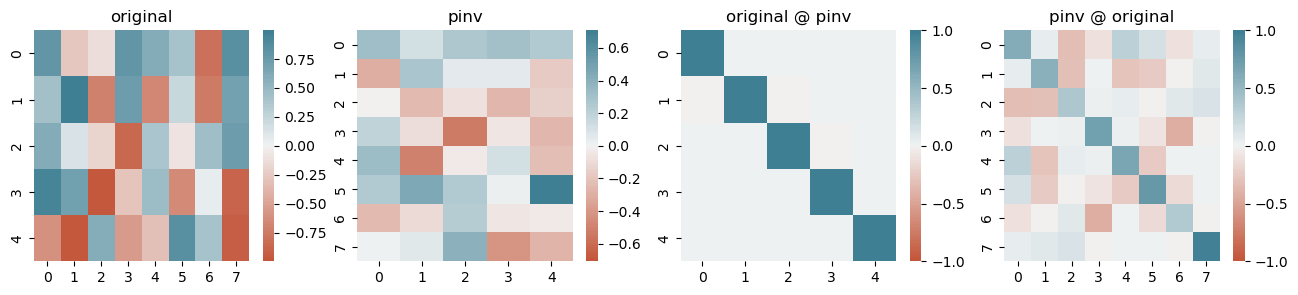



-------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8
0,-0.670612,0.242957,0.154457,-0.524214,0.868428,0.227932,0.071266,0.179820,0.460244
1,-0.376110,-0.203558,-0.580313,-0.627614,0.888745,0.479102,-0.019082,-0.545171,-0.491287
2,-0.883942,-0.131167,-0.376408,0.392687,-0.244496,-0.640793,-0.950643,-0.865501,0.358786
3,-0.092606,0.073158,0.793343,0.980678,-0.566206,0.326156,-0.473355,-0.958698,0.516757
4,-0.359966,-0.233072,0.176634,0.662097,0.257964,0.745301,-0.452916,0.596094,-0.628728


,0,1,2,3,4
0,-0.387862,0.084326,-0.343716,0.091266,-0.219497
1,0.221100,-0.130663,-0.064231,0.059336,-0.109365
2,0.294844,-0.189518,-0.250365,0.339593,0.025684
3,-0.140393,-0.165421,0.079344,0.146439,0.314110
4,0.344633,0.214781,-0.060319,-0.002201,0.077152
5,0.050887,0.331411,-0.347330,0.356430,0.213405
6,0.014262,0.050170,-0.331687,0.048091,-0.259491
7,0.214979,-0.543536,0.006267,-0.438948,0.366537
8,0.470358,-0.297768,0.042218,0.146172,-0.267236


,0,1,2,3,4
0,1.000000e+00,1.314341e-17,-4.062957e-16,3.866670e-16,-3.585119e-16
1,-1.832986e-16,1.000000e+00,8.720208e-17,1.758552e-16,1.915753e-16
2,-7.800159e-16,2.594526e-16,1.000000e+00,-1.687629e-16,1.584670e-16
3,7.551597e-17,1.694706e-16,-2.504949e-16,1.000000e+00,-5.109359e-18
4,-2.157258e-17,1.642417e-16,-1.248497e-16,1.903945e-16,1.000000e+00


,0,1,2,3,4,5,6,7,8
0,0.602773,-0.008479,0.054168,-0.040400,-0.286146,0.038421,0.353713,-0.036569,-0.158093
1,-0.008479,0.118571,0.161910,-0.073341,0.029779,-0.033203,0.100757,0.044507,0.242331
2,0.054168,0.161910,0.523710,0.216104,-0.036823,0.266741,0.090256,0.062774,0.298319
3,-0.040400,-0.073341,0.216104,0.560155,-0.290223,0.119772,-0.293860,0.043113,-0.076695
4,-0.286146,0.029779,-0.036823,-0.290223,0.526071,0.276891,0.043902,0.045185,-0.018191
5,0.038421,-0.033203,0.266741,0.119772,0.276891,0.668248,0.062116,-0.085410,-0.214001
6,0.353713,0.100757,0.090256,-0.293860,0.043902,0.062116,0.410139,0.061503,0.050912
7,-0.036569,0.044507,0.062774,0.043113,0.045185,-0.085410,0.061503,0.968863,-0.089058
8,-0.158093,0.242331,0.298319,-0.076695,-0.018191,-0.214001,0.050912,-0.089058,0.621471


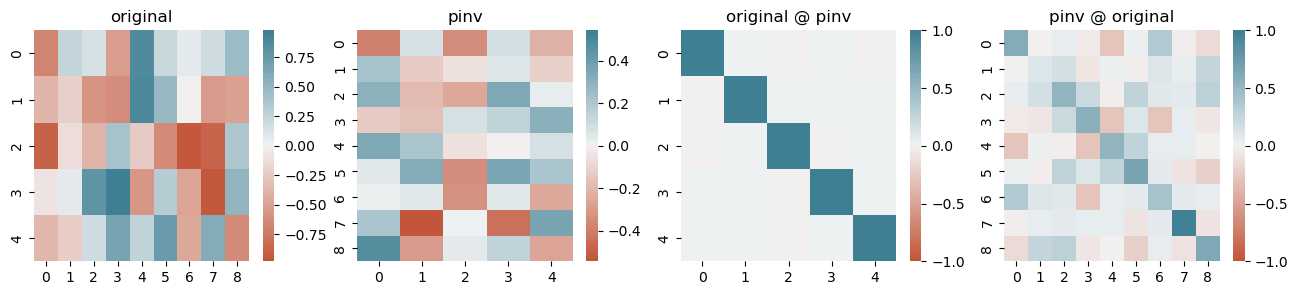



-------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9
0,0.905583,0.374977,-0.568985,0.894741,0.461712,-0.492117,-0.573376,0.036401,-0.948675,-0.585060
1,-0.150629,-0.251660,-0.072849,-0.444743,0.173569,0.727711,-0.764936,0.034758,-0.735864,0.433719
2,-0.207881,0.130843,-0.633440,-0.710304,-0.023887,-0.288775,0.880864,0.530651,0.497327,0.807439
3,-0.833155,0.104385,0.168952,0.923873,-0.415705,-0.518342,-0.799412,-0.967141,0.859059,0.339833
4,0.570306,-0.436540,0.172820,-0.872089,-0.028745,0.954990,0.753010,-0.323682,0.923140,-0.536597


,0,1,2,3,4
0,0.446846,0.027253,0.125720,0.010545,0.353395
1,0.094048,-0.104963,0.098163,0.012029,-0.081664
2,-0.613093,-0.354684,-0.662466,-0.331646,-0.324843
3,0.103175,-0.235306,-0.160694,0.108199,-0.126590
4,0.205475,0.124982,0.114251,0.003869,0.093327
5,-0.022938,0.369045,-0.095561,0.008995,0.279919
6,-0.186524,-0.442546,0.033558,-0.280205,-0.057619
7,-0.225818,-0.180636,-0.038730,-0.392555,-0.348026
8,0.087087,-0.104704,0.238023,0.352967,0.355548
9,0.005721,0.340453,0.405314,0.185372,-0.086524


,0,1,2,3,4
0,1.000000e+00,3.531208e-16,-2.192660e-16,2.679750e-16,-5.564887e-16
1,-8.355260e-16,1.000000e+00,-7.932783e-16,-1.008151e-15,-7.460223e-16
2,-4.614005e-16,-2.168563e-16,1.000000e+00,-4.351393e-17,1.249835e-16
3,4.117158e-16,-1.586606e-16,2.996862e-16,1.000000e+00,4.661996e-16
4,5.964047e-18,3.903295e-16,4.955100e-16,3.648326e-16,1.000000e+00


,0,1,2,3,4,5,6,7,8,9
0,0.567174,0.023978,-0.273015,-0.000059,0.193499,0.095650,0.091366,-0.040659,-0.046150,-0.334147
1,0.023978,0.111430,-0.120127,0.143436,0.020207,-0.235236,0.041724,0.066665,-0.028217,0.026621
2,-0.273015,-0.120127,0.682140,0.056630,-0.181605,0.096594,0.059812,0.039710,-0.071617,-0.268433
3,-0.000059,0.143436,0.056630,0.521468,-0.030706,-0.352581,-0.202533,-0.153364,-0.028556,-0.187473
4,0.193499,0.020207,-0.181605,-0.030706,0.109543,0.043961,-0.045595,0.038501,-0.140600,-0.022521
5,0.095650,-0.235236,0.096594,-0.352581,0.043961,0.570100,-0.149728,-0.138021,-0.031199,-0.050825
6,0.091366,0.041724,0.059812,-0.202533,-0.045595,-0.149728,0.655640,0.285284,0.225390,-0.120022
7,-0.040659,0.066665,0.039710,-0.153364,0.038501,-0.138021,0.285284,0.457255,-0.330615,0.075847
8,-0.046150,-0.028217,-0.071617,-0.028556,-0.140600,-0.031199,0.225390,-0.330615,0.744246,0.024991
9,-0.334147,0.026621,-0.268433,-0.187473,-0.022521,-0.050825,-0.120022,0.075847,0.024991,0.581004


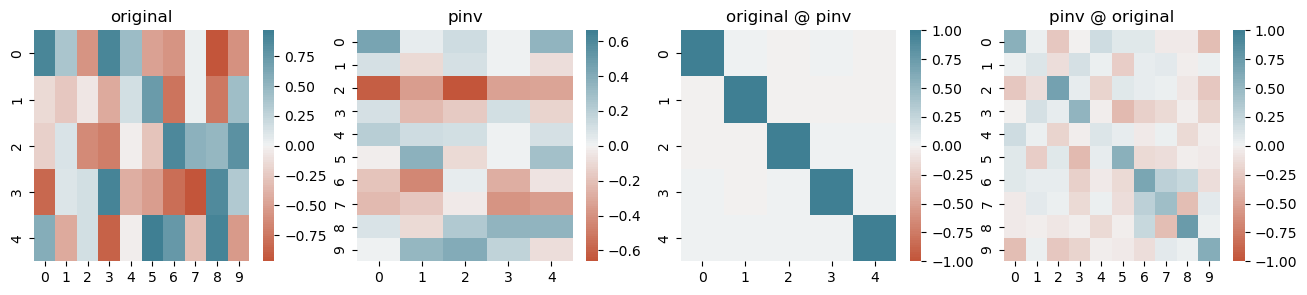

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def generate_random_matrix(rows, cols):
    return np.random.uniform(low=-1.0, high=1.0, size=(rows, cols))


def display_pseudoinverse(mat):
    mat_pinv = np.linalg.pinv(mat)
    mat_confm = mat @ mat_pinv
    mat_confm2 = mat_pinv @ mat

    max_abs_mat = max(abs(mat.max()), abs(mat.min()))
    max_abs_mat_pinv = max(abs(mat_pinv.max()), abs(mat_pinv.min()))
    max_abs_mat_confm = max(abs(mat_confm.max()), abs(mat_confm.min()))

    df1 = pd.DataFrame(mat)
    df2 = pd.DataFrame(mat_pinv)
    df3 = pd.DataFrame(mat_confm)
    df4 = pd.DataFrame(mat_confm2)

    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1)
    plt.title("original")
    sns.heatmap(mat,
                # annot=True,
                vmin=-1*max_abs_mat,
                vmax=1*max_abs_mat,
                cmap=sns.diverging_palette(20,220,n=100))
    plt.subplot(1,4,2)
    plt.title("pinv")
    sns.heatmap(mat_pinv,
                # annot=True,
                vmin=-1*max_abs_mat_pinv,
                vmax=1*max_abs_mat_pinv,
                cmap=sns.diverging_palette(20,220,n=100))
    plt.subplot(1,4,3)
    plt.title("original @ pinv")
    sns.heatmap(mat_confm,
                # annot=True,
                vmin=-1*max_abs_mat_confm,
                vmax=1*max_abs_mat_confm,
                cmap=sns.diverging_palette(20,220,n=100))
    plt.subplot(1,4,4)
    plt.title("pinv @ original")
    sns.heatmap(mat_confm2,
                # annot=True,
                vmin=-1*max_abs_mat_confm,
                vmax=1*max_abs_mat_confm,
                cmap=sns.diverging_palette(20,220,n=100))

    print("-------------------------------------------------------------------")
    display(df1)
    print()
    display(df2)
    print()
    display(df3)
    print()
    display(df4)
    print()
    plt.show()
    print()
    print()


np.random.seed(seed=0)

N_mat = 10
rows = 5
cols = 1

for i in range(N_mat):
    mat = generate_random_matrix(rows, cols)
    cols += 1
    display_pseudoinverse(mat)

##